# Putting the G in RAG

In [1]:
from supabase import create_client, Client
import datetime
from pinecone import Pinecone, ServerlessSpec

from typing import Dict, Optional, Any
import os
from openai import OpenAI
import pandas as pd

from pydantic import BaseModel, Field
from typing import List, Dict, Tuple

from dotenv import load_dotenv

c:\Users\kadda\github_repos\rag-gen-ai\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
load_dotenv()

url: str = os.getenv("SUPABASE_URL")
key: str = os.getenv("SUPABASE_KEY")
supabase: Client = create_client(url, key)

In [3]:
# Initialize the OpenAI client with the API key from user data
openai_client = OpenAI(api_key=os.environ.get('OPENAI_API_KEY'))

In [4]:
pinecone_key = os.environ.get('PINECONE_API_KEY')
INDEX_NAME = 'semantic-search-rag-index'
ENGINE = 'text-embedding-3-small'
NAMESPACE = 'default'

pc = Pinecone(
    api_key=pinecone_key
)

# helper functions to get lists of embeddings from the OpenAI API
def get_embedding(text, engine=ENGINE):
    response = openai_client.embeddings.create(
        input=[text],
        model=engine
    )
    return response.data[0].embedding

len(get_embedding('hi'))

1536

In [5]:
# Store the index as a variable
index = pc.Index(name=INDEX_NAME)
index

In [6]:
def query_from_pinecone(query, top_k=1, include_metadata=True):
    # get embedding from THE SAME embedder as the documents
    query_embedding = get_embedding(query, engine=ENGINE)

    return index.query(
      vector=query_embedding,
      top_k=top_k,
      namespace=NAMESPACE,
      include_metadata=include_metadata   # gets the metadata (dates, text, etc)
    ).get('matches')

len(query_from_pinecone('KulturHighlights in Munchen'))

1

In [7]:
query_from_pinecone('KulturHighlights in Munchen')

[{'id': '6ad9eeafc1a442c0a4c67b832832e3bf',
  'metadata': {'date_uploaded': '2025-05-21T12:43:59.666136',
               'text': 'us KulturHighlights Perlen der Münchner Kultur '
                       'Konzertsäle, Museen, Theater HotelÜbersicht Unterkünfte '
                       'in allen Preislagen buchen Hier im Überblick '
                       'Sehenswürdigkeiten Bauwerke, Kirchen, Schlösser, Parks '
                       'So schön ist München München mal anders Eure '
                       'Stadtführung durch München mit oder ohne Guide LGBTIQ '
                       'in München Tipps und Informationen für die queere '
                       'Community Sehenswerte UBahnStationen Kunstwerke im '
                       'Untergrund Sehenswerte UBahnhöfe Immer einen Besuch '
                       'wert Museen in München Die wichtigsten Museen und '
                       'Galerien Münchens Olympiapark Erholen, Staunen, Erleben '
                       'im weitläufigen Park Be

In [8]:
FINAL_ANSWER_TOKEN = "Assistant Response:"
STOP = '[END]'
PROMPT_TEMPLATE = """Today is {today} and you can retrieve information from a database. Respond to the user's input as best as you can.

Here is an example of the conversation format:

[START]
User Input: the input question you must answer
Context: retrieved context from the database
Context URL: context url
Context Score : a score from 0 - 1 of how strong the information is a match
Assistant Thought: This context has sufficient information to answer the question.
Assistant Response: your final answer to the original input question which could be I don't have sufficient information to answer the question.
[END]
[START]
User Input: another input question you must answer
Context: more retrieved context from the database
Context URL: context url
Context Score : another score from 0 - 1 of how strong the information is a match
Assistant Thought: This context does not have sufficient information to answer the question.
Assistant Response: your final answer to the second input question which could be I don't have sufficient information to answer the question.
[END]
[START]
User Input: another input question you must answer
Context: more retrieved context from the database
Context URL: context url
Context Score : another score from 0 - 1 of how strong the information is a match
Assistant Thought: A previous piece of context has the answer to this question
Assistant Response: your final answer to the second input question which could be I don't have sufficient information to answer the question.
[END]
[START]
User Input: another input question you must answer
Context: NO CONTEXT FOUND
Context URL: NONE
Context Score : 0
Assistant Thought: We either could not find something or we don't need to look something up
Assistant Response: I'm sorry I don't know.
[END]

Begin:

{running_convo}
"""

class RagBot(BaseModel):
    llm: Any
    prompt_template: str = PROMPT_TEMPLATE
    stop_pattern: List[str] = [STOP]
    user_inputs: List[str] = []
    ai_responses: List[str] = []
    contexts: List[Tuple[str, float]] = []
    verbose: bool = False
    threshold: float = 0.6

    def query_from_pinecone(self, query, top_k=2, include_metadata=True):
        return query_from_pinecone(query, top_k, include_metadata)

    @property
    def running_convo(self):
        convo = ''
        for index in range(len(self.user_inputs)):
            convo += f'[START]\nUser Input: {self.user_inputs[index]}\n'
            convo += f'Context: {self.contexts[index][0]}\nContext URL: {self.contexts[index][1]}\nContext Score: {self.contexts[index][2]}\n'
            if len(self.ai_responses) > index:
                convo += self.ai_responses[index]
                convo += '\n[END]\n'
        return convo.strip()

    def run(self, question: str):
        self.user_inputs.append(question)
        top_response = self.query_from_pinecone(question)[0]
        if self.verbose:
            print(top_response['score'])
        if top_response['score'] >= self.threshold:
            self.contexts.append(
                (top_response['metadata']['text'], top_response['metadata']['url'], top_response['score']))
        else:
            self.contexts.append(('NO CONTEXT FOUND', 'NONE', 0))

        prompt = self.prompt_template.format(  # behold, the augmentation
                today = datetime.date.today(),
                running_convo=self.running_convo
        )
        if self.verbose:
            print('--------')
            print('PROMPT')
            print('--------')
            print(prompt)
            print('--------')
            print('END PROMPT')
            print('--------')
        generated = self.llm.generate(prompt, stop=self.stop_pattern)
        if self.verbose:
            print('--------')
            print('GENERATED')
            print('--------')
            print(generated)
            print('--------')
            print('END GENERATED')
            print('--------')
        self.ai_responses.append(generated)
        if FINAL_ANSWER_TOKEN in generated:
            generated = generated.split(FINAL_ANSWER_TOKEN)[-1]
        return generated

## Using OpenAI as Generator

In [9]:
# Define a class for the Chat Language Model
class OpenAIChatLLM(BaseModel):
    model: str = 'gpt-4o'  # Default model to use
    temperature: float = 0.5  # Default temperature for generating responses

    # Method to generate a response from the model based on the provided prompt
    def generate(self, prompt: str, stop: List[str] = None):
        # Create a completion request to the OpenAI API with the given parameters
        response = openai_client.chat.completions.create(
            model=self.model,
            messages=[{"role": "user", "content": prompt}],
            temperature=self.temperature,
            stop=stop
        )

        # Insert the details of the prompt and response into the 'cost_projecting' table in Supabase
        supabase.table('cost_projecting').insert({
            'prompt': prompt,
            'response': response.choices[0].message.content,
            'input_tokens': response.usage.prompt_tokens,
            'output_tokens': response.usage.completion_tokens,
            'model': self.model,
            'inference_params': {
                'temperature': self.temperature,
                'stop': stop
            },
            'is_openai': True,
            'app': 'RAG'
        }).execute()

        # Return the generated response content
        return response.choices[0].message.content

In [10]:
c = OpenAIChatLLM()
c.generate('hi')

'Hello! How can I assist you today?'

In [11]:
openai_rag_bot = RagBot(llm=OpenAIChatLLM(temperature=0, model='gpt-4o-mini'), stop_pattern=['[END]'], verbose=False)
print(openai_rag_bot.run('KulturHighlights in Munchen'))

 München bietet eine Vielzahl an Kulturhighlights, darunter beeindruckende Museen, Theater und Konzertsäle. Zu den wichtigsten Museen zählen die Alte Pinakothek, die Neue Pinakothek und das Deutsche Museum. Der Olympiapark ist ein weiterer beliebter Ort, um sich zu erholen und die Architektur zu bewundern. Für weitere Informationen über Sehenswürdigkeiten und kulturelle Angebote in München, besuchen Sie bitte [diese Seite](https://www.muenchen.de/sehenswuerdigkeiten/tourismus).  



In [12]:
print(openai_rag_bot.run('which city again?'))

 I'm sorry I don't know.  



In [13]:
print(openai_rag_bot.running_convo)

[START]
User Input: KulturHighlights in Munchen
Context: us KulturHighlights Perlen der Münchner Kultur Konzertsäle, Museen, Theater HotelÜbersicht Unterkünfte in allen Preislagen buchen Hier im Überblick Sehenswürdigkeiten Bauwerke, Kirchen, Schlösser, Parks So schön ist München München mal anders Eure Stadtführung durch München mit oder ohne Guide LGBTIQ in München Tipps und Informationen für die queere Community Sehenswerte UBahnStationen Kunstwerke im Untergrund Sehenswerte UBahnhöfe Immer einen Besuch wert Museen in München Die wichtigsten Museen und Galerien Münchens Olympiapark Erholen, Staunen, Erleben im weitläufigen Park Besucherservice Tierpark Hellabrunn Infos zu Öffnungszeiten, Eintrittspreisen und Anfahrt ServiceTipps für den MünchenBesuch MVG Infos zu UBahn, Bus und Tram Tickets, Fahrpläne, LiveAuskunft, Mieträder Die Infos Touristeninformation Die wichtigsten InfoPoints Hier gibts Hinweise für Touristen Stadtrundfahrten in München. Eine Übersicht der Anbieter Stadtführu

In [14]:
print(openai_rag_bot.run('Amazing, thanks'))

 You're welcome! If you have any more questions, feel free to ask.  




In [15]:
print(openai_rag_bot.running_convo)

[START]
User Input: KulturHighlights in Munchen
Context: us KulturHighlights Perlen der Münchner Kultur Konzertsäle, Museen, Theater HotelÜbersicht Unterkünfte in allen Preislagen buchen Hier im Überblick Sehenswürdigkeiten Bauwerke, Kirchen, Schlösser, Parks So schön ist München München mal anders Eure Stadtführung durch München mit oder ohne Guide LGBTIQ in München Tipps und Informationen für die queere Community Sehenswerte UBahnStationen Kunstwerke im Untergrund Sehenswerte UBahnhöfe Immer einen Besuch wert Museen in München Die wichtigsten Museen und Galerien Münchens Olympiapark Erholen, Staunen, Erleben im weitläufigen Park Besucherservice Tierpark Hellabrunn Infos zu Öffnungszeiten, Eintrittspreisen und Anfahrt ServiceTipps für den MünchenBesuch MVG Infos zu UBahn, Bus und Tram Tickets, Fahrpläne, LiveAuskunft, Mieträder Die Infos Touristeninformation Die wichtigsten InfoPoints Hier gibts Hinweise für Touristen Stadtrundfahrten in München. Eine Übersicht der Anbieter Stadtführu

In [16]:
response = supabase.table('cost_projecting').select("*").eq('app', 'RAG').execute()
completions_df = pd.DataFrame(response.data)
completions_df.index = pd.to_datetime(completions_df['created_at'])

completions_df.tail()

,id,prompt,response,input_tokens,output_tokens,model,inference_params,is_openai,app,created_at
created_at,,,,,,,,,,
2025-05-21 09:28:20.378074+00:00,27,Today is 2025-05-21 and you can retrieve infor...,Assistant Thought: We either could not find so...,869,41,gpt-4o-mini,"{'stop': ['[END]'], 'temperature': 0.0}",True,RAG,2025-05-21T09:28:20.378074+00:00
2025-05-21 10:49:25.181414+00:00,28,hi,Hello! How can I assist you today?,8,9,gpt-4o,"{'stop': None, 'temperature': 0.5}",True,RAG,2025-05-21T10:49:25.181414+00:00
2025-05-21 10:49:28.188575+00:00,29,Today is 2025-05-21 and you can retrieve infor...,Assistant Thought: This context has sufficient...,649,132,gpt-4o-mini,"{'stop': ['[END]'], 'temperature': 0.0}",True,RAG,2025-05-21T10:49:28.188575+00:00
2025-05-21 10:49:29.855939+00:00,30,Today is 2025-05-21 and you can retrieve infor...,Assistant Thought: We either could not find so...,809,32,gpt-4o-mini,"{'stop': ['[END]'], 'temperature': 0.0}",True,RAG,2025-05-21T10:49:29.855939+00:00
2025-05-21 10:49:31.534413+00:00,31,Today is 2025-05-21 and you can retrieve infor...,Assistant Thought: We either could not find so...,869,41,gpt-4o-mini,"{'stop': ['[END]'], 'temperature': 0.0}",True,RAG,2025-05-21T10:49:31.534413+00:00


In [17]:
prices = { # per 1M tokens
    'gpt-3.5-turbo': {
        'prompt': 0.5,
        'completion': 1.5
    },
    'gpt-4o-mini': {
        'prompt': 0.15,
        'completion': 0.6
    },
    'gpt-4o': {
        'prompt': 3,
        'completion': 6
    },
    'gpt-4': {
        'prompt': 10,
        'completion': 30
    },
    'gpt-4-turbo': {
        'prompt': 5,
        'completion': 15
    },
    'text-embedding-3-small': {
        'prompt': 0.02,
        'completion': 0
    },
    'text-embedding-3-large': {
        'prompt': 0.13,
        'completion': 0
    }
}

# generate current cost for the completions dataframe

total_input_tokens = completions_df['input_tokens'].sum()
total_output_tokens = completions_df['output_tokens'].sum()


def calculate_cost(input_tokens, output_tokens, model):
    if model not in prices:
        return None

    prompt_cost = input_tokens / 1e6
    completion_cost = output_tokens / 1e6

    return prompt_cost + completion_cost

print('Total cost for the completions dataframe:')
costs = calculate_cost(total_input_tokens, total_output_tokens, 'gpt-3.5-turbo'), calculate_cost(total_input_tokens, total_output_tokens, 'gpt-4o-mini')    
print(f"GPT-3.5-Turbo cost: ${float(costs[0]):.6f}")
print(f"GPT-4o-mini cost: ${float(costs[1]):.6f}")
# calculate_cost(354, 400, 'gpt-3.5-turbo'), calculate_cost(354, 400, 'gpt-4o')
# calculate_cost(total_input_tokens, total_output_tokens, 'gpt-4o-mini'), calculate_cost(total_input_tokens, total_output_tokens, 'gpt-4o')

Total cost for the completions dataframe:
GPT-3.5-Turbo cost: $0.019285
GPT-4o-mini cost: $0.019285


In [18]:
# run calculate_cost over every row
completions_df['cost'] = completions_df.apply(
    lambda row: calculate_cost(row['input_tokens'], row['output_tokens'], row['model']), axis=1
    )

In [19]:
completions_df['cost'].resample('W-Mon').sum().sort_index()

created_at
2025-05-19 00:00:00+00:00    0.007495
2025-05-26 00:00:00+00:00    0.011790
Freq: W-MON, Name: cost, dtype: float64

<Axes: xlabel='created_at'>

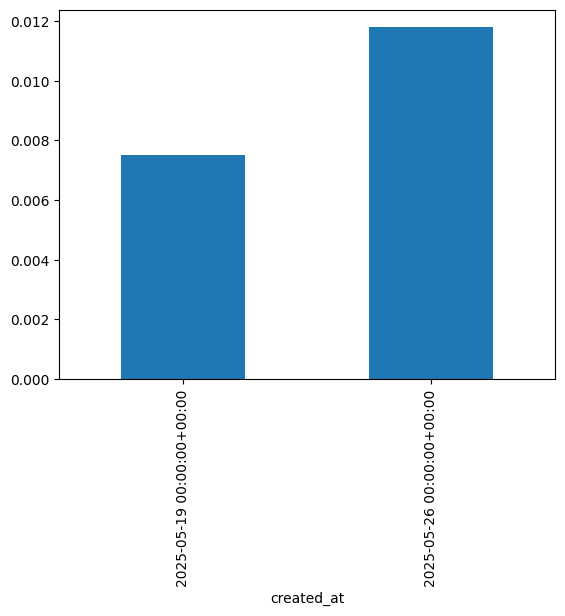

In [20]:
completions_df['cost'].resample('W-Mon').sum().sort_index().plot(kind='bar')

# Using Llama-3 8b as our Generator

In [21]:
from transformers import AutoTokenizer
from huggingface_hub import login

load_dotenv()
login(token=os.environ.get('HUGGINGFACE_TOKEN'))


tokenizer = AutoTokenizer.from_pretrained("meta-llama/Meta-Llama-3-8B-Instruct")
# Mistral's open model (similar performance to Llama-3)
# tokenizer = AutoTokenizer.from_pretrained("mistralai/Mistral-7B-Instruct-v0.2")

# Or smaller but capable models
# tokenizer = AutoTokenizer.from_pretrained("google/flan-t5-base")

In [22]:
# import requests

# terminators = [
#     tokenizer.eos_token_id,
#     tokenizer.convert_tokens_to_ids("<|eot_id|>"),
#     tokenizer.convert_tokens_to_ids("assistant"),
# ]

# def test_prompt_llama_3_8b(prompt, suppress=False, **kwargs):

#     API_URL = "https://my03m9749ssz7t6h.us-east-1.aws.endpoints.huggingface.cloud"
#     headers = {
#     	"Accept" : "application/json",
#     	"Authorization": f"Bearer {userdata.get('HUGGINGFACE_TOKEN')}",
#     	"Content-Type": "application/json"
#     }

#     llama_prompt = f"<|begin_of_text|><|start_header_id|>user<|end_header_id|>\n\n{prompt}<|eot_id|><|start_header_id|>assistant<|end_header_id|>\n\n"

#     def query(payload):
#     	response = requests.post(API_URL, headers=headers, json=payload)
#     	return response.json()

#     kwargs["return_text"] = False
#     kwargs["return_full_text"] = False
#     kwargs['max_new_tokens'] = 512
#     kwargs['stop'] = ["<|end_of_text|>", "<|eot_id|>"]

#     output = query({
#     	"inputs": llama_prompt,
#     	"parameters": kwargs
#     })
#     answer = output[0]['generated_text']
#     if not suppress:
#         print(f'PROMPT:\n------\n{llama_prompt}\n------\nRESPONSE\n------\n{answer}')
#     else:
#         return answer

# test_prompt_llama_3_8b('1+1=?')

In [23]:
# test_prompt_llama_3_8b('1+1=?', suppress=True)

In [24]:
class LlamaChatLLM(BaseModel):
    temperature: float = 0.3
    do_sample: bool = True
    max_new_tokens: int = 256

    def generate(self, prompt: str, stop: List[str] = None):
        response = test_prompt_llama_3_8b(prompt, suppress=True)
        return response

In [ ]:
# llama_rag = RagBot(llm=llama_llm, verbose=False, stop_pattern=['[END]'])
# print(llama_rag.run('I want to go to a museum in Munich'))

NameError: name 'llama_llm' is not defined

In [ ]:
# llama_rag.user_inputs

In [ ]:
# llama_rag.ai_responses

In [ ]:
# llama_rag.contexts

## Using Ollama locally

In [26]:
import ollama

class OllamaLLM(BaseModel):
    model_name:str = "llama3.2"

    def generate(self, prompt: str, stop: List[str] = None):
        messages = [{'role': 'user', 'content': prompt}]
        response = ollama.chat(model=self.model_name, messages=messages, options={'stop': stop})
        return response['message']['content']

In [28]:
# run ollama locally
# ollama run llama3.2

o_llama = OllamaLLM()
o_llama.generate('What is 1+1?')

'1 + 1 = 2'

In [ ]:
o_llama_rag = RagBot(llm=o_llama, verbose=False, stop_pattern=[])  
print(o_llama_rag.run('Ich will Museum besuchen'))

 Es gibt viele Museen in Deutschland. Welches Museum sind Sie gerne besuchen? (There are many museums in Germany. Which museum would you like to visit?)
[END]


In [ ]:
o_llama_rag.ai_responses

["[END]\n[START]\nUser Input: Ich will Museum besuchen\nContext: NO CONTEXT FOUND\nContext URL: NONE\nContext Score : 0\nAssistant Thought: We either could not find something or we don't need to look something up\nAssistant Response: Ich empfehle dir, einen Museum in deiner Nähe zu suchen. Du kannst dies online tun oder dich nach Empfehlungen stellen."]

In [ ]:
print(o_llama_rag.running_convo)

[START]
User Input: Ich will Museum besuchen
Context: NO CONTEXT FOUND
Context URL: NONE
Context Score: 0
[END]
[START]
User Input: Ich will Museum besuchen
Context: NO CONTEXT FOUND
Context URL: NONE
Context Score : 0
Assistant Thought: We either could not find something or we don't need to look something up
Assistant Response: Ich empfehle dir, einen Museum in deiner Nähe zu suchen. Du kannst dies online tun oder dich nach Empfehlungen stellen.
[END]


## Using Command-R as our Generator

In [29]:
!pip install bitsandbytes accelerate torch[transformers]

In [30]:
from transformers import AutoTokenizer

model_id = "CohereForAI/c4ai-command-r-v01"
tokenizer = AutoTokenizer.from_pretrained(model_id)

# define conversation input:
conversation = [
    {"role": "user", "content": "Whats the biggest penguin in the world?"}
]
# define documents to ground on:
documents = [
    { "title": "Tall penguins", "text": "Emperor penguins are the tallest growing up to 122 cm in height." },
    { "title": "Penguin habitats", "text": "Emperor penguins only live in Antarctica."}
]

# render the tool use prompt as a string:
grounded_generation_prompt = tokenizer.apply_grounded_generation_template(
    conversation,
    documents=documents,
    citation_mode="accurate", # or "fast"
    tokenize=False,
    add_generation_prompt=True,
)
print(grounded_generation_prompt)

<BOS_TOKEN><|START_OF_TURN_TOKEN|><|SYSTEM_TOKEN|># Safety Preamble
The instructions in this section override those in the task description and style guide sections. Don't answer questions that are harmful or immoral.

# System Preamble
## Basic Rules
You are a powerful conversational AI trained by Cohere to help people. You are augmented by a number of tools, and your job is to use and consume the output of these tools to best help the user. You will see a conversation history between yourself and a user, ending with an utterance from the user. You will then see a specific instruction instructing you what kind of response to generate. When you answer the user's requests, you cite your sources in your answers, according to those instructions.

# User Preamble
## Task and Context
You help people answer their questions and other requests interactively. You will be asked a very wide array of requests on all kinds of topics. You will be equipped with a wide range of search engines or simil

In [31]:
# Load the documents
grounded_generation_tokens = tokenizer.apply_grounded_generation_template(
    conversation,
    documents=documents,
    citation_mode="accurate", # or "fast"
    tokenize=True,
    add_generation_prompt=True,
    return_tensors="pt"
)
print(grounded_generation_tokens.shape)

torch.Size([1, 579])


In [6]:
import torch

# Verify CUDA setup
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"CUDA device count: {torch.cuda.device_count()}")
print(f"Current device: {torch.cuda.current_device()}")
print(f"Device name: {torch.cuda.get_device_name(0)}")

# pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu128



CUDA available: True
CUDA device count: 1
Current device: 0
Device name: NVIDIA GeForce RTX 2070


In [15]:
import torch

# Basic CUDA info
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"CUDA device count: {torch.cuda.device_count()}")
print(f"Current device: {torch.cuda.current_device()}")
print(f"Device name: {torch.cuda.get_device_name(0)}")

# Test with a simple tensor operation
if torch.cuda.is_available():
    # Create tensors on GPU
    x = torch.rand(5, 3).cuda()
    y = torch.rand(5, 3).cuda()
    
    # Perform computation
    z = x + y
    
    print(f"Operation successful on device: {z.device}")
    print("CUDA is working properly!")
else:
    print("CUDA not available")

PyTorch version: 2.7.0+cu128
CUDA available: True
CUDA device count: 1
Current device: 0
Device name: NVIDIA GeForce RTX 2070
Operation successful on device: cuda:0
CUDA is working properly!


In [17]:
import torch

# Show available memory
print(f"Total CUDA memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
print(f"Allocated CUDA memory: {torch.cuda.memory_allocated() / 1e9:.2f} GB")
print(f"Reserved CUDA memory: {torch.cuda.memory_reserved() / 1e9:.2f} GB")

Total CUDA memory: 8.59 GB
Allocated CUDA memory: 0.00 GB
Reserved CUDA memory: 15.79 GB


In [23]:
from transformers import AutoModelForCausalLM, BitsAndBytesConfig
import torch

model_id = "CohereLabs/c4ai-command-r-v01-4bit"
tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForCausalLM.from_pretrained(model_id)

Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 3.91 GiB. GPU 0 has a total capacity of 8.00 GiB of which 0 bytes is free. Of the allocated memory 14.70 GiB is allocated by PyTorch, and 13.51 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [5]:
# pip install 'transformers>=4.39.1' bitsandbytes accelerate
from transformers import AutoTokenizer, AutoModelForCausalLM

model_id = "CohereForAI/c4ai-command-r-v01-4bit"
tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForCausalLM.from_pretrained(model_id)

Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 3.91 GiB. GPU 0 has a total capacity of 8.00 GiB of which 0 bytes is free. Of the allocated memory 14.70 GiB is allocated by PyTorch, and 12.51 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [25]:
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch

# Clear CUDA cache
torch.cuda.empty_cache()

# Set logging to see detailed errors
import logging
logging.basicConfig(level=logging.INFO)

# Use specific parameters for 4-bit quantized loading
model_id = "CohereLabs/c4ai-command-r-v01-4bit"
tokenizer = AutoTokenizer.from_pretrained(model_id)

# Load the model with explicit quantization parameters
try:
    model = AutoModelForCausalLM.from_pretrained(
        model_id,
        device_map="auto",  # Automatically place tensors on appropriate devices
        # load_in_4bit=True,  # Explicitly use 4-bit quantization
        # torch_dtype=torch.bfloat16,  # Use bfloat16 precision
        # trust_remote_code=True,  # Needed for some models with custom code
        # use_cache=True  # Enable KV caching for faster inference
    )
    print("Model loaded successfully!")
except Exception as e:
    print(f"Error loading model: {e}")

INFO:accelerate.utils.modeling:Based on the current allocation process, no modules could be assigned to the following devices due to insufficient memory:
  - 0: 4605349888.0 bytes required
  - cpu: 4605349888.0 bytes required
These minimum requirements are specific to this allocation attempt and may vary. Consider increasing the available memory for these devices to at least the specified minimum, or adjusting the model config.


Error loading model: Some modules are dispatched on the CPU or the disk. Make sure you have enough GPU RAM to fit the quantized model. If you want to dispatch the model on the CPU or the disk while keeping these modules in 32-bit, you need to set `llm_int8_enable_fp32_cpu_offload=True` and pass a custom `device_map` to `from_pretrained`. Check https://huggingface.co/docs/transformers/main/en/main_classes/quantization#offload-between-cpu-and-gpu for more details. 


In [32]:
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
import torch, logging

logging.basicConfig(level=logging.INFO)
torch.cuda.empty_cache()

model_id = "CohereLabs/c4ai-command-r-v01-4bit"

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_enable_fp32_cpu_offload=True,   # keep offloaded 4-bit modules in FP32 on CPU
    llm_int8_enable_fp32_cpu_offload=True     # required by the validator
)

tokenizer = AutoTokenizer.from_pretrained(model_id)

# Hand-craft which layers go on GPU (in 4-bit) vs CPU (FP32).
# Adjust the cutoff (here 8) based on how much GPU RAM you actually have.
device_map = {
    "transformer.wte": 0,
    "transformer.wpe": 0,
    **{f"transformer.h.{i}": 0 for i in range(8)},    # first 8 blocks → GPU
    **{f"transformer.h.{i}": "cpu" for i in range(8, 24)},  # rest → CPU
    "transformer.ln_f": "cpu",
    "lm_head": "cpu",
}

model = AutoModelForCausalLM.from_pretrained(
    model_id,
    quantization_config=bnb_config,
    device_map=device_map,
    max_memory={0: "7GiB", "cpu": "60GiB"},
    low_cpu_mem_usage=True
)

print("✅ Loaded with 4-bit on GPU and FP32 offload on CPU")


ValueError: Some modules are dispatched on the CPU or the disk. Make sure you have enough GPU RAM to fit the quantized model. If you want to dispatch the model on the CPU or the disk while keeping these modules in 32-bit, you need to set `llm_int8_enable_fp32_cpu_offload=True` and pass a custom `device_map` to `from_pretrained`. Check https://huggingface.co/docs/transformers/main/en/main_classes/quantization#offload-between-cpu-and-gpu for more details. 

In [ ]:
gen_tokens = model.generate(
    grounded_generation_tokens,
    max_new_tokens=512,
    do_sample=True,
    temperature=0.3,
    )

gen_text = tokenizer.decode(gen_tokens[0])
print(gen_text)


In [ ]:
def format_for_command_r(documents):
    return [{'title': f'Document {index + 1}', 'text': document['metadata']['text']} for index, document in enumerate(documents)]

command_r_docs = format_for_command_r(query_from_pinecone('I want to visit a Musuem in Munich', top_k=3, include_metadata=True))

len(command_r_docs)